<a href="https://colab.research.google.com/github/clomia/AIB-Section1-Project/blob/master/DataAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from typing import Tuple
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline

data = pd.read_csv('https://drive.google.com/uc?export=download&id=1wH6BUzfoXJx_yrOVNj7Ewt2lFJ5MGIPW')
origin_data = data.copy()

# Pre-processing

## 판매량 데이터 전처리

판매량을 환산하는 함수입니다.  
기본값으로 백만단위를 사용하며, 0으로 표기된것은  
단위에 미치지 못한 0이상의 숫자라고 간주하여 (단위/2)값으로 대체합니다  .
  
( 단위로는 K = 1_000 , M = 1000_000 , 기본 = 1000_000 입니다. )

In [2]:
def numericization(value):
    M = 1000_000
    K = 1_000

    def KM_product(number,unit):
        result = number * unit
        return result if result else unit/2

    logic_dict = {
        'K':lambda value: KM_product( float(value), K ),
        'M':lambda value: KM_product( float(value), M ),
    }
    try:
        result = KM_product( float(value), M )
    except ValueError:
        unit,number = value[-1],value[:-1]
        result = logic_dict[unit](number)
    return np.int64(result)

## 출시년도 데이터 전처리  

연도 데이터에서 잘못된 값과 결측치를 처리합니다. 
   
**잘못된 값 복구**  
잘못된 값은 연도 범위에서 벗어난 두자리 숫자입니다.  
데이터 분석 결과 잘못된 값은 무조건 20이하이거나 80이상입니다.  
또한 올바른 연도데이터가 가지는 범위는 (1980 ~ 2020) 입니다.  
즉, 잘못된 값이 20이하인 경우 2000을 더하고,  
80 이상인 경우 1900을 더해서 올바른 연도로 복구합니다. 
  
**결측치 처리**  
위에서 처리된 데이터의 평균,표준편차,분산을 모방하는  
데이터셋를 생성하여 결측치를 매꿉니다.  
결과적으로 데이터의 통계치 회손을 최소화합니다.

아래 코드는 간단하게 데이터를 확인하는 작업입니다.

In [3]:
normal_elements , denormal_elements = [] , []


class Filter:
    def __init__(self, normal:bool , container:list):
        self.normal = normal
        self.container = container
    
    def __call__(self,func):
        def wrapper(year):
            return_value = func(year)
            if not return_value:
                if not self.normal:
                    self.container.append(np.nan)
                return
            length,year = return_value
            if self.normal and length == 4:
                self.container.append(year)
            elif (not self.normal) and length != 4:
                self.container.append(year)
            return return_value
        return wrapper

    @staticmethod                
    def function(year):
        try:
            year = np.int64(year)
        except ValueError:
            return 
        else:
            return len(str(year)),year

        
@Filter(normal=True,container=normal_elements)
def normal_sampling(year):
    return Filter.function(year)

@Filter(normal=False,container=denormal_elements)
def denormal_sampling(year):
    return Filter.function(year)


data['Year'].apply(denormal_sampling)
data['Year'].apply(normal_sampling)


# "assertion failed"가 발생하지 않는것을 통해서 NAN이 아닌 비정상적인 년도는 모두 20이하이거나 80이상이라는것을 증명합니다.
filter_20_to_80 = tuple( value for value in denormal_elements if value <= 20 or value >= 80 )
filter_not_nan = tuple( value for value in denormal_elements if value is not np.nan )
assert filter_20_to_80 == filter_not_nan

round_int = lambda number:int(round(number,0))
data_info = {
    '평균':round_int(np.mean(normal_elements)),
    '분산':round_int(np.var(normal_elements)),
    '표준편차':round_int(np.std(normal_elements)),
}
# 평균:2006 , 표준편차:6

missing_values = tuple( object for value in denormal_elements if value is np.nan )
MISSING_VALUE_COUNT = len(missing_values)

print(f'올바른 연도값의 최대와 최소: {min(normal_elements)} , {max(normal_elements)}')
print(f'결측치 갯수:{MISSING_VALUE_COUNT}') # 결측치 갯수: 271개

올바른 연도값의 최대와 최소: 1980 , 2020
결측치 갯수:271


결측치를 매꾸기 위한 데이터셋을 생성합니다.  
**기존 데이터의 평균과 표준편차를 모방한 데이터셋**을 생성하고 올바른지 테스트합니다.

In [4]:
sampling = lambda : round_int(data_info['표준편차'] * np.random.randn() + data_info['평균'])
sample = [ sampling() for _ in range(MISSING_VALUE_COUNT) ]

print(f"기존 데이터-> 평균:{data_info['평균']} , 분산:{data_info['분산']} , 표준편차:{data_info['표준편차']}")
print(f"모방 생성한 데이터-> 평균:{round_int(np.mean(sample))} , 분산:{round_int(np.var(sample))} , 표준편차:{round_int(np.std(sample))}")

기존 데이터-> 평균:2006 , 분산:34 , 표준편차:6
모방 생성한 데이터-> 평균:2006 , 분산:34 , 표준편차:6


위에서 진행한 분석을 기반으로 연도 데이터를 처리하는 함수입니다.

In [5]:
def year_product(value):
    try:
        value = np.int64(value)
    except ValueError:
        value = sample.pop()
        return value if value < 2021 else 2020
    else:
        if 1980 <= value <= 2020:
            return value
        return value + ( 2000 if value <= 20 else 1900 )

## 판매량과 출시년도에 데이터 처리 적용

In [6]:
target = ['NA_Sales','EU_Sales','JP_Sales','Other_Sales']
data[target] = data[target].applymap(numericization) # 판매 데이터 처리
data['Total_Sales'] = data['NA_Sales'] + data['EU_Sales'] + data['JP_Sales'] + data['Other_Sales']	
data.index = data['Year'].apply(year_product) # 출시년도 데이터 처리
data = data.drop(['Unnamed: 0','Year'],axis=1).sort_index(ascending=False) 
data.head()

,Name,Platform,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_Sales
Year,,,,,,,,,
2020,Imagine: Makeup Artist,DS,Simulation,Ubisoft,270000,500,500000,20000,790500
2020,Swords,Wii,Fighting,Unknown,30000,500000,500000,500000,1530000
2020,Port Royale 3,PS3,Simulation,Kalypso Media,60000,500000,500000,10000,1070000
2020,Yoostar on MTV,X360,Misc,Unknown,60000,500000,500000,500000,1560000
2020,Final Fantasy XI,PS2,Role-Playing,Unknown,80000,60000,150000,20000,310000


## Genre와 Publisher의 NaN값 대체  
Genre 결측치는 "Misc" 으로 대체
Publisher 결측치는 "Unknown"으로 대체

In [7]:
genre_missing_data = data['Genre'][ data['Genre'].isin([np.nan]) ]
publisher_missing_data = data['Publisher'][ data['Publisher'].isin([np.nan]) ]

data['Genre'] = data['Genre'].fillna('Misc')
data['Publisher'] = data['Publisher'].fillna('Unknown')

print(f'처리한 NaN 갯수| Genre:{len(genre_missing_data)} , Publisher:{len(publisher_missing_data)}')
data.info()

처리한 NaN 갯수| Genre:50 , Publisher:58
<class 'pandas.core.frame.DataFrame'>
Int64Index: 16598 entries, 2020 to 1980
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Name         16598 non-null  object
 1   Platform     16598 non-null  object
 2   Genre        16598 non-null  object
 3   Publisher    16598 non-null  object
 4   NA_Sales     16598 non-null  int64 
 5   EU_Sales     16598 non-null  int64 
 6   JP_Sales     16598 non-null  int64 
 7   Other_Sales  16598 non-null  int64 
 8   Total_Sales  16598 non-null  int64 
dtypes: int64(5), object(4)
memory usage: 1.3+ MB


데이터 전처리 종료.

# 필수 내용

In [8]:
# Constant 정의
extract = lambda name: tuple(set(data[name].values))

GENRES,PLATFORMS,PUBLISHER = extract('Genre') , extract('Platform') , extract('Publisher')
REGIONS = ('NA_Sales','EU_Sales','JP_Sales')
YEARS = tuple(range(1980,2021))

## 지역에 따라서 선호하는 게임 장르가 다를까  
North America, European Union, Japan  
  
[PlatForm은 비디오 게임 및 액션 장르의 하위장르이다.](https://en.wikipedia.org/wiki/Platform_game)

**결론**  
지역에 따라서 선호하는 게임 장르는 다릅니다.  
지역별로 40년간 가장 많이 판매된 장르는 아래와 같습니다.  
북아메리카 -> 플랫폼  
유럽 -> 롤플레잉  
일본 -> 플랫폼  
기타 -> 어드벤쳐  
  
하지만 이것은 그냥 전체 데이터의 평균값이며    
연도별 트렌드가 전혀 반영되지 않은 결과입니다.  



In [9]:
def visualization(region):
    sns.barplot(x=region, y="Genre", data=data)
    plt.title(f"{region} Data")

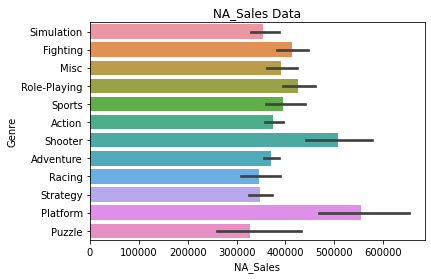

In [10]:
visualization("NA_Sales") # Top: Platform

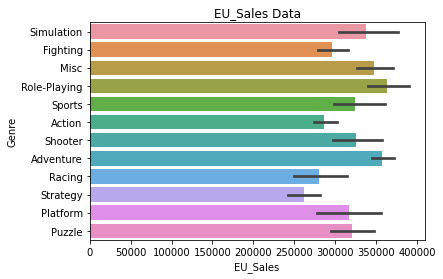

In [11]:
visualization("EU_Sales") # Top: Role-Playing

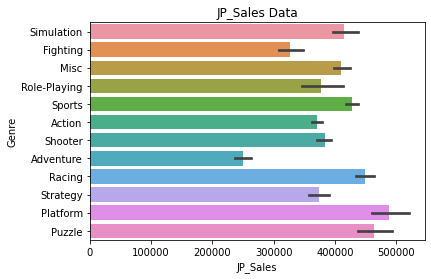

In [12]:
visualization("JP_Sales") # Top: Platform

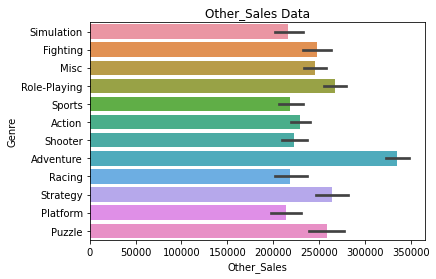

In [13]:
visualization("Other_Sales") # Top: Adventure

장르별로 ANOVA 분석

In [14]:
anova_result = []
for genre in GENRES:
    oper_df = data[ data['Genre'] == genre ]
    groups = [ oper_df[region] for region in REGIONS ]
    _,p_value = stats.f_oneway(*groups)
    if p_value < 0.05:
        print(f"지역에 따라서 {genre}장르의 선호도는 유의미한 차이를 보입니다.")	
        anova_result.append(genre)
result = f"지역에 따라서 선호하는 게임 장르가 {'다릅'if tuple(anova_result)==GENRES else'다르지 않습'}니다."
print(result)

지역에 따라서 Strategy장르의 선호도는 유의미한 차이를 보입니다.
지역에 따라서 Shooter장르의 선호도는 유의미한 차이를 보입니다.
지역에 따라서 Fighting장르의 선호도는 유의미한 차이를 보입니다.
지역에 따라서 Adventure장르의 선호도는 유의미한 차이를 보입니다.
지역에 따라서 Platform장르의 선호도는 유의미한 차이를 보입니다.
지역에 따라서 Simulation장르의 선호도는 유의미한 차이를 보입니다.
지역에 따라서 Action장르의 선호도는 유의미한 차이를 보입니다.
지역에 따라서 Racing장르의 선호도는 유의미한 차이를 보입니다.
지역에 따라서 Misc장르의 선호도는 유의미한 차이를 보입니다.
지역에 따라서 Sports장르의 선호도는 유의미한 차이를 보입니다.
지역에 따라서 Puzzle장르의 선호도는 유의미한 차이를 보입니다.
지역에 따라서 Role-Playing장르의 선호도는 유의미한 차이를 보입니다.
지역에 따라서 선호하는 게임 장르가 다릅니다.


## 연도별 게임의 트렌드가 있을까

**결론**  
연도별 게임의 트렌드가 있습니다.  


**장르**  
옛날에는 플랫폼 게임과 슈팅게임이 많이 유행했지만  
2000년대를 넘어서면서 둘 다 점유율이 거의 사라지는 추세입니다.   
  
스포츠 게임은 안정적인 점유율을 유지하고 있습니다.  
(튼튼한 메니아층이 받쳐주는 장르일수도 있습니다.)  
  
RPG게임과 액션게임 모두 상승세를 보이고 있지만  
RPG게임의 경우 액션게임보다 안정적이지 않은 모습을 보입니다.  

(RPG 게임은 게임 내 성장을 기반으로 하는 만큼 다른 게임으로 갈아타는 회전률이 낮기 때문인 것으로 추측됩니다.  
반면에 액션게임은 컨트롤을 중시하는 만큼 회전률이 높기 때문에 비교적 안정적인 수치를 보이는것 같습니다.)  

최근들어서는 액션게임 못지않게 전략게임도 큰 수요를 보이고 있습니다.  
  

**플랫폼**

1980년도경 시기에는 아타리2600이 거의 100%의 점유율을 차지했으나,  
얼마 안가서 닌텐도에게 그 자리를 내주게 됩니다.  
이후 닌텐도의 인기가 식으면서 아타리2600이 부활하는듯 싶더니,  
슈퍼닌텐도가 등장하면서 점유율을 모두 먹어치웁니다.  
하지만 슈퍼닌텐도의 인기는 5년도 채 되지 않아서 1995년경 PS(플스)에게 추월당하고 맙니다.  
이후 PS2가 나오면서 대략 7년정도 높은 점유율을 유지합니다.
  
최근에는 대부분의 점유율을 PC가 차지하고 있습니다  

### TrendAnalysis Object

In [15]:
import os
from concurrent.futures import ProcessPoolExecutor

class TrendAnalysis:
    """ 
    주어진 DataFrame를 Genre,Platform,Publisher 피처들로 나눈 뒤
    각 피처별로 피처를 구성하는 카테고리 별 판매 비율을 연도별로 산출합니다.  
    이렇게 산출된 결과를 쉽게 다루기 위한 API를 제공합니다.
    데이터는 DataFrame으로 제공됩니다.  

    -- 데이터 접근 기본 API --
    TA = TrendAnalysis(df)
    TA.info.genre
    TA.info.platform
    TA.info.publisher

    -- 상위 데이터 필터링 API --
    Syntax: TA.info.top(count).피처.연산범위

    예시 (recent_range인자를 통해서 최근연도 범위를 지정): 
    TA = TrendAnalysis(data,recent_range=10)

    TA.info.top(5).genre.recent  
    반환: 최근 10년간 총 판매량이 Top 5 안에 드는 장르에 대한 DataFrame
    TA.info.top(3).platform.total
    반환: 총 판매량이 Top 3 안에 드는 플랫폼에 대한 DataFrame

    -- 시각화 API --
    통합: TA.lineplot(피처)
    예시: TA.lineplot(TrendAnalysis.genre)

    단일: TA.lineplot(피처,피처내부카테고리) 
    예시: TA.lineplot(TrendAnalysis.genre,"Puzzle")

    추출된 상위 데이터로 시각화할때는 df인자 사용:
    TA.lineplot(df=TA.info.top(5).genre.recent)
    """

    genre = "genre"
    platform = "platform"
    publisher = "publisher"
    features = (genre,platform,publisher)
    
    def __init__(self,data:pd.DataFrame,recent_range:int=3,multiprocessing=True):
        self.data = data
        self.info = self._multiprocessing() if multiprocessing else self._processing()
        self.recent_range = list(range(2019-recent_range,2020)) # 2020은 결측치가 많아서 제외

        def excract_top(count):
            attr = {}
            for kind in self.features:
                total_data,recent_data = self.top_data_extraction(kind,count)
                attr[kind] = type('TotalOrRecent',(),{'total':total_data,'recent':recent_data})

            return type('TopData',(),attr)

        self.info.top = excract_top
    
    def lineplot(self,attr:str=None,y:str=None,save_name:str=None,df=None):
        """ x축이 연도인 line plot을 그립니다. """

        if df is None:
            df = self.info.__dict__[attr]
            if y:
                plot = sns.lineplot(x=df.index,y=y,data=df)
                plt.title(y.capitalize(),fontsize=20)
            else:
                plot = sns.lineplot(data=df)
                plt.title(attr.capitalize(), fontsize=20)
        else:
            plot = sns.lineplot(data=df)
            plt.legend(fontsize=12,bbox_to_anchor=(1.7, 1))
        
        plt.ylabel('Sales', fontsize=14)
        plt.xlabel('Year', fontsize=14)
        plt.ylim(0, 100)

        if save_name:
            plt.savefig(f'./{save_name}')

        plt.show()
        return plot

    
    def top_data_extraction(self,attr:str,count:int):
        """ 기간동안 평균적으로 점유율이 높은 상위 카테고리만 추출합니다. """
        df = self.info.__dict__[attr]
        recent_data = df.loc[self.recent_range]
        get_name,r_get_name,lst,r_lst = {},{},[],[]
        for column in df.columns:
            total = df[column].sum()
            recent_total = recent_data[column].sum()
            get_name[total] = column
            r_get_name[recent_total] = column
            lst.append(total)
            r_lst.append(recent_total)
        lst.sort(reverse=True)
        r_lst.sort(reverse=True)
        total_data = df[[ get_name[key] for key in lst[:count] ]]
        recent_data = df[[ r_get_name[key] for key in r_lst[:count] ]]
        return total_data,recent_data
 
    def _percentification(self,column,year):
        """ data에서 column의 종류별 판매 비율을 연도별로 산출합니다. """ 
        result = {}
        try:
            total = self.data.loc[year]['Total_Sales'].sum()
        except KeyError:
            return { key:0 for key in extract(column) }

        for kind in extract(column):
            try:
                target_data = self.data[ self.data[column] == kind ].loc[year]
            except KeyError:
                result[kind] = 0
            else:    
                result[kind] = ( target_data['Total_Sales'].sum()/total )*100
        return result

    def _processing(self):
        property_data = {
            self.genre : pd.DataFrame(index=YEARS,columns=GENRES),
            self.platform : pd.DataFrame(index=YEARS,columns=PLATFORMS),
            self.publisher : pd.DataFrame(index=YEARS,columns=PUBLISHER),
        }

        for year in YEARS:
            property_data[self.genre].loc[year] = self._percentification('Genre',year)
            property_data[self.platform].loc[year] = self._percentification('Platform',year)
            property_data[self.publisher].loc[year] = self._percentification('Publisher',year)
        
        result = { key:value.astype(float) for key,value in property_data.items() }
        return type('Info',(),result)

    def _operation(self,args):
        target,columns = args
        df = pd.DataFrame(index=YEARS,columns=columns)
        for year in YEARS:
            df.loc[year] = self._percentification(target.capitalize(),year)
        return target,df

    def _multiprocessing(self):   
        property_data = {}
        pool = ProcessPoolExecutor(max_workers=os.cpu_count())
        args = (
            (self.genre,GENRES),
            (self.platform,PLATFORMS),
            (self.publisher,PUBLISHER),
        )
        operator = pool.map(self._operation,args)
        for result in operator:
            target,df = result
            property_data[target] = df.astype(float)

        return type('Info',(),property_data)

In [16]:
analysis_result = TrendAnalysis(data)

### 연도별 점유율

#### 장르

전채 점유율 Top 5 의 데이터

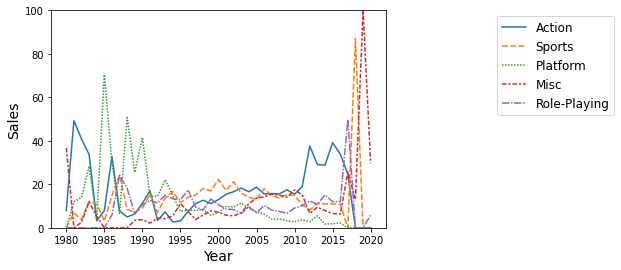

In [17]:
analysis_result.lineplot(df=analysis_result.info.top(5).genre.total);

최근 3년간 점유율 Top 5 의 데이터

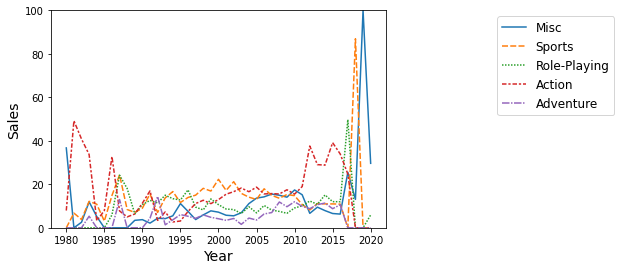

In [18]:
analysis_result.lineplot(df=analysis_result.info.top(5).genre.recent,save_name='genre.png');

#### 플랫폼

전채 점유율 Top 5 의 데이터

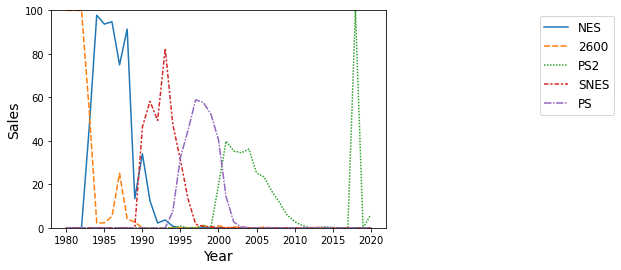

In [19]:
analysis_result.lineplot(df=analysis_result.info.top(5).platform.total);

최근 3년간 점유율 Top 5 의 데이터

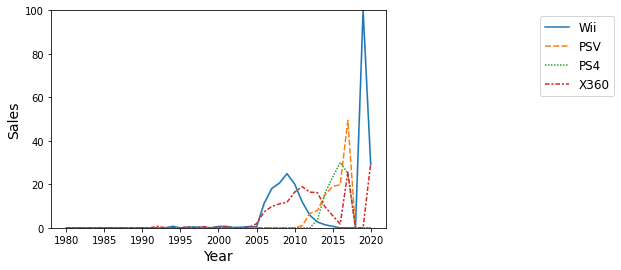

In [20]:
analysis_result.lineplot(df=analysis_result.info.top(5).platform.recent,save_name='platform.png');

#### 회사

전채 점유율 Top 5 의 데이터

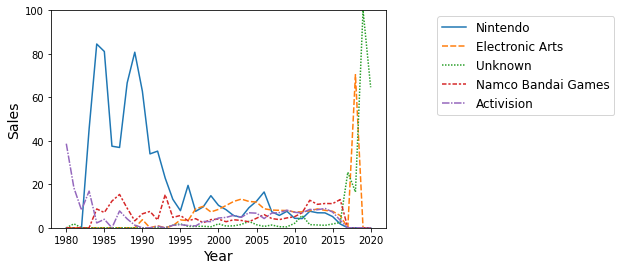

In [21]:
analysis_result.lineplot(df=analysis_result.info.top(5).publisher.total);

최근 3년간 점유율 Top 5 의 데이터

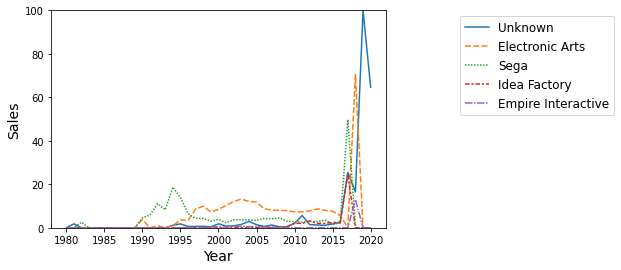

In [22]:
analysis_result.lineplot(df=analysis_result.info.top(5).publisher.recent,save_name='publisher.png');

### 장르의 연도별 점유율 상세  
총 11개 (기타 제외)    
Puzzle, Simulation, Strategy, Racing, Platform, Shooter, Role-Playing, Fighting, Sports, Action, Adventure

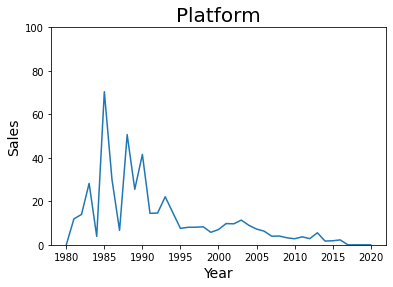

In [23]:
analysis_result.lineplot(TrendAnalysis.genre,"Platform"); # 플랫폼

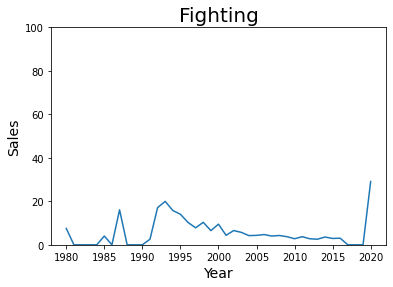

In [24]:
analysis_result.lineplot(TrendAnalysis.genre,"Fighting"); # 격투

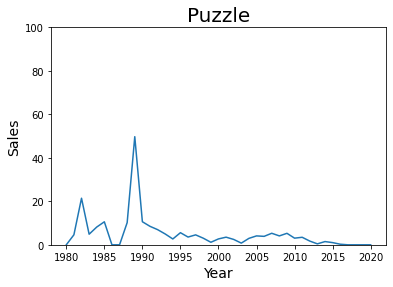

In [25]:
analysis_result.lineplot(TrendAnalysis.genre,"Puzzle"); # 퍼즐

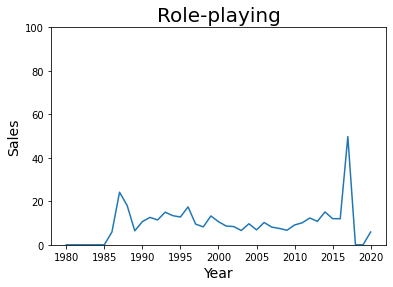

In [26]:
analysis_result.lineplot(TrendAnalysis.genre,"Role-Playing"); # 롤플레잉

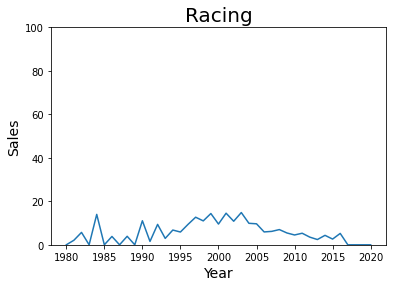

In [27]:
analysis_result.lineplot(TrendAnalysis.genre,"Racing"); # 레이싱

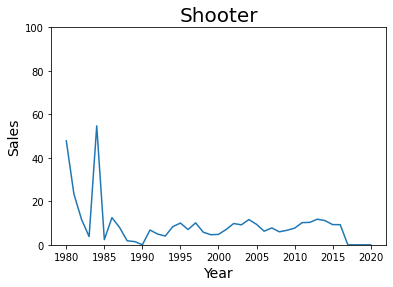

In [28]:
analysis_result.lineplot(TrendAnalysis.genre,"Shooter"); # 슈팅

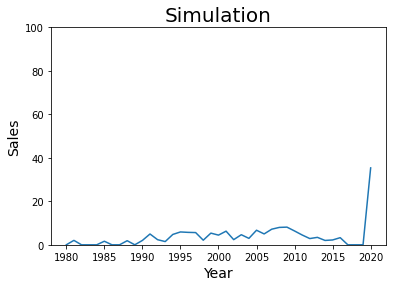

In [29]:
analysis_result.lineplot(TrendAnalysis.genre,"Simulation"); # 시뮬레이션

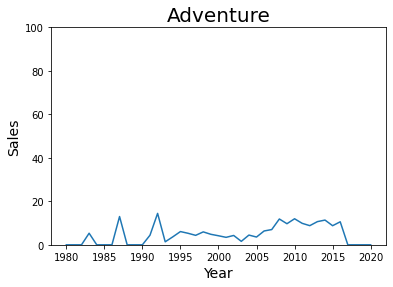

In [30]:
analysis_result.lineplot(TrendAnalysis.genre,"Adventure"); # 어드벤처

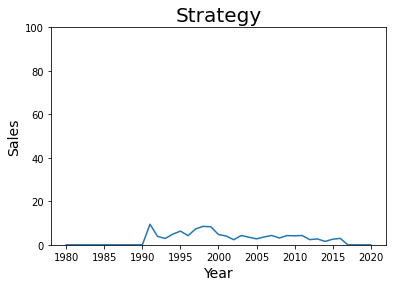

In [31]:
analysis_result.lineplot(TrendAnalysis.genre,"Strategy"); # 전략

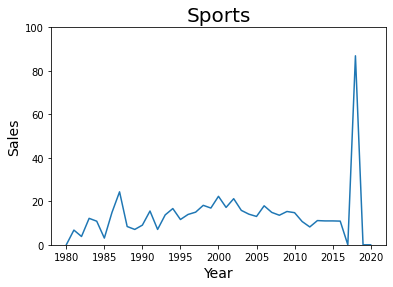

In [32]:
analysis_result.lineplot(TrendAnalysis.genre,"Sports"); # 스포츠

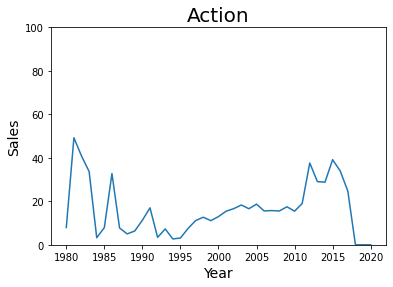

In [33]:
analysis_result.lineplot(TrendAnalysis.genre,"Action"); # 액션

## 출고량이 높은 게임에 대한 분석 및 시각화 프로세스

출고량이 높았던 게임 5개입니다.

In [34]:
data.sort_values('Total_Sales',ascending=False).head()

,Name,Platform,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_Sales
Year,,,,,,,,,
2006,Wii Sports,Wii,Sports,Nintendo,41490000,29020000,3770000,8460000,82740000
1985,Super Mario Bros.,NES,Platform,Nintendo,29080000,3580000,6810000,770000,40240000
2008,Mario Kart Wii,Wii,Racing,Nintendo,15850000,12880000,3790000,3310000,35830000
2009,Wii Sports Resort,Wii,Sports,Nintendo,15750000,11010000,3280000,2960000,33000000
1996,Pokemon Red/Pokemon Blue,GB,Role-Playing,Nintendo,11270000,8890000,10220000,1000000,31380000


출고량이 높은 항목 중 (Will Sports,Mario Kart Wii,Wii Sports Resort) 의 경우  
모두 Will 플랫폼 게임입니다.  
   
위에서 진행한 시각화에 기반하여 생각했을때,  
최근 3년 혹은 총 기간동안 플랫폼 상위 점유율에 Will이 없는것으로 보아  
2006년 ~ 2009 년 사이에 Will플랫폼 자체가 크게 유행했던 것으로 추측됩니다.  
  
즉 해당 게임들은 Will 플랫폼의 인기몰이와 상부상조하며 성공한 케이스라고 생각됩니다.  
  


Super Mario Bros 게임은 플랫폼과 장르 모든 면에서 전반적인 판매 통계와 딱 들어맞는 위치에 있습니다.  
게임이 발매된 1985년은 플랫폼 장르의 판매량이 가장 높았으며,  
NES플랫폼이 거의 독점하던 시기였습니다.  

Pokemon Red/Pokemon Blue 게임도 마찬가지입니다.  
게임이 발매된 시기에 롤플레잉 장르와 스포츠 장르가 양대산맥을 이루고 있었습니다.  